# Project: Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Libraries
We are going to use mainly :
- matplotlib for image rendering
- OpenCV for image manipulation
- Scikit-Learn for the SVM classifier and ML utilities
- Numpy


In [1]:
import glob

import numpy as np
import cv2

from skimage.feature import hog
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

## Handy functions
First I define two functions that might be useful. The first one is to display two image side-by-side which is nice when you need to compare an original image with a transformed one. The second function is to draw several rectangles on top of an image.

In [2]:
## two figures size by size
def plot_2_images(im1, im2, title1='Original Image', title2='Modified Image'):
    """
    Plot two images side-by-side for comparison.
    :param im1: Original image in BGR format
    :param im2: Modified image. Can be in different format 
    :param title1: Title to display above first image
    :param title2: Title to display on second image
    :return: 
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.tight_layout()
    # BGR to RGB conversion
    #ax1.imshow(im1[:, :, ::-1])
    ax1.imshow(im1)
    ax1.set_title(title1, fontsize=16)
    if len(im2.shape)==2:
        ax2.imshow(im2, cmap='gray')
    else :
        #ax2.imshow(im2[:,:,::-1])
        ax2.imshow(im2)
    ax2.set_title(title2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return ax1, ax2

def draw_bounding_boxes(image,bbox_list):
    # bbox should be made of four elements, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right))
    for bbox in bbox_list:
        cv2.rectangle(image,bbox[0], bbox[1],(255,0,0),2)
    
    return image


## Available data
Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

In [3]:
TRAINING_IMAGES_PATH='./training_images/'

img_list_1 = glob.glob(TRAINING_IMAGES_PATH+'/vehicles/*/*')
label_1 = [1]*len(img_list_1)

img_list_2 = glob.glob(TRAINING_IMAGES_PATH+'/non-vehicles/*/*')
label_2 = [0]*len(img_list_2)

train_img_list = img_list_1+img_list_2
labels = label_1 + label_2

Let's have a look at one image from each class:

(<matplotlib.axes._subplots.AxesSubplot at 0x11fa4fa58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11fac55f8>)

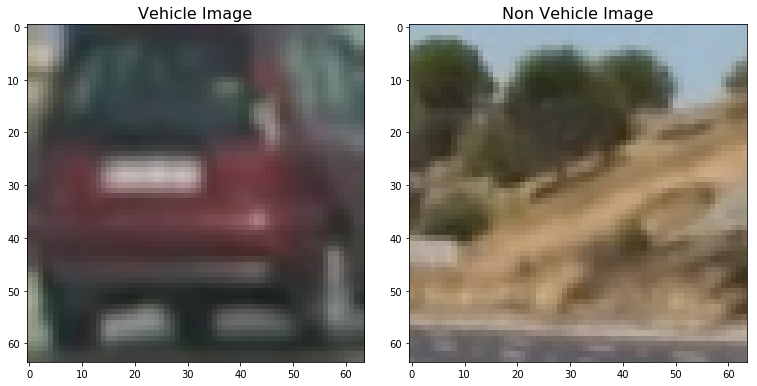

In [4]:
img1 = mpimg.imread(img_list_1[80])
img2 = mpimg.imread(img_list_2[80])
plot_2_images(img1, img2, title1='Vehicle Image', title2='Non Vehicle Image')

## Image Features
To make a classifier, we will need to extract some useful features from the images. These features will be passed to a linear classifier to decide whether the image shows a car or not.

### Color features
Color features use the raw pixel values. We can do this in two different way : 
- We can take the whole image, rescale it to a smaller size, and flatten the matrix into a vector
- We can make an histogram of pixel values and take the values of the histogram as features.

Both approach can be applied simultaneously, and the relevance of the features will depend on the color space chosen. We can here choose between the following color spaces :
- RGB
- HSV
- LUV
- HLS
- YUV
- YCrCb

In [5]:
def set_color_space(img,color_space='RGB'):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             

    return feature_image

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return features


### HOG features
Other features are based on the histogram of oriented gradient.

In [6]:
# Define a function to return HOG features
def hog_features(img, hog_channel='ALL', orient=9, pix_per_cell=8, cell_per_block=2, feature_vec=True):
    if hog_channel == 'ALL':
        hog_feat = []
        for channel in range(img.shape[2]):
            hog_feat.append(hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), visualise=False, 
                                feature_vector=feature_vec, block_norm="L2-Hys"))
        hog_feat = np.ravel(hog_feat)        
    else:
        hog_feat = hog(img[:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), visualise=False, 
                                feature_vector=feature_vec, block_norm="L2-Hys")
    
    return hog_feat

In [7]:
# Define a function to return HOG features and visualization
def hog_features_visu(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True):
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image


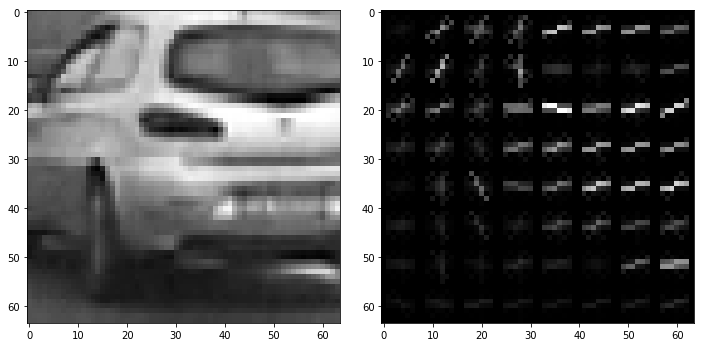

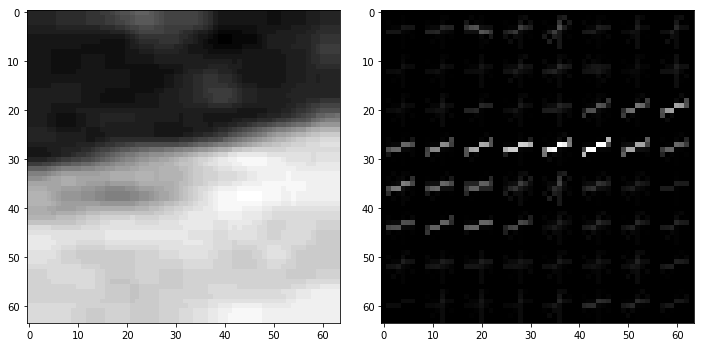

In [8]:
idx = np.arange(len(train_img_list))
np.random.seed(1)
np.random.shuffle(idx)
for i in idx[:2]:
    fname=train_img_list[i]
    img = cv2.imread(fname) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    feat, hog_image=hog_features_visu(img[:,:,0])
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.tight_layout()
    ax1.imshow(img[:,:,0],cmap='gray')
    ax2.imshow(hog_image,cmap='gray')

### Creating feature set
The following function extract features from an individual image. The next function create the training set with a specified set of parameters. 

In [9]:
def get_features_single_image(img,spatial = True, histogram=True, hog=True, color_space='RGB', size=(32, 32), 
                              nbins=128, bins_range=(0, 256), hog_channel='ALL', orient=11, pix_per_cell=16, 
                              cell_per_block=2, feature_vec=True):    
    feature_image = set_color_space(img, color_space=color_space)
    if spatial == True:
        spat_feat = bin_spatial(feature_image, size=size)
    else :
        spat_feat = np.array([])
    if histogram == True:
        hist_feat = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
    else : 
        hist_feat = np.array([])
    if hog == True:
        hog_feat = hog_features(feature_image, hog_channel=hog_channel, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec = feature_vec)
    else : 
        hog_feat = np.array([])
    return np.concatenate((spat_feat, hist_feat, hog_feat))

In [10]:
def build_training_set(file_list,*args,**kwargs):
    features_list = [] 
    for fname in file_list:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        features = get_features_single_image(img,*args,**kwargs)
        features_list.append(features)
        
    return np.array(features_list)

## Linear SVM Classifier

Now we can construct binary classifier and evaluate its performance. The following function performs K-folds cross-validation for a given classifier on the training set and return the average accuracy, as well as the standard deviation over the K folds. Since they proved to be efficient, we will mostly work with SVM's.

In [11]:
def eval_accuracy(X,y,classifier,nfolds=5,*args,**kwargs):
    X, y = shuffle(X, y, random_state=0)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    clf = classifier(*args,**kwargs)
    scores = cross_val_score(clf, scaled_X, y, cv=nfolds)
    
    return np.round(np.mean(scores),3), np.round(np.std(scores),3)

### Feature sets selection and parameter tuning
Now we will choose the set of features that works well. In order to limit the computational time it takes to evaluate on set of features, we will restrict ourselves to 2000 training examples chosen randomly. We will perform a five-fold cross-validation to evaluate the performance of the classifier.

In [12]:
nsamples = 2000
_, img_list, _,  y = train_test_split(train_img_list,labels,test_size=nsamples,stratify=np.array(labels),
                                      random_state=12345)
y=np.array(y)

#### HOG features

(2000, 1188) (2000,)


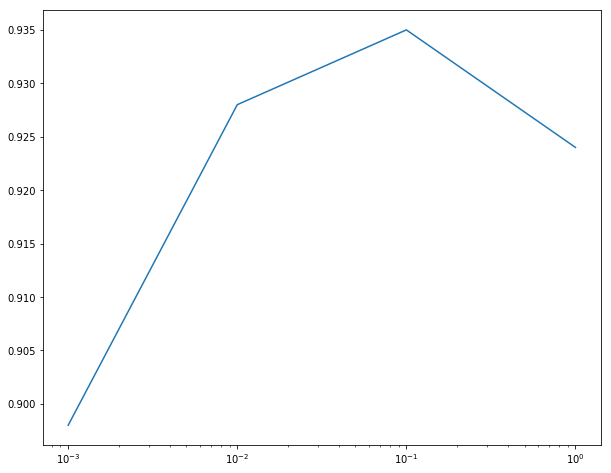

In [13]:
X = build_training_set(img_list,spatial=False,histogram=False)
print(X.shape,y.shape)

C = 10.**(np.arange(-3,1,1))
mean_scores = []
for c in C:
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)
plt.semilogx(C,mean_scores)

Now we can make a grid search on the parameter of the HOG feature to determine which is the most effective.

In [14]:
import itertools
hog_channel=['ALL',0,1,2]
orient=[9,11,13]
pix_per_cell=[8,16] 
grid = itertools.product(hog_channel,orient,pix_per_cell)
print('hog_channel | orient | pix_per_cell | score')
for hc,o,ppc in grid:
    X = build_training_set(img_list,spatial=False,histogram=False,hog_channel=hc,orient=o,pix_per_cell=ppc)
    mean, std = eval_accuracy(X, y, LinearSVC, C=1e-3)
    print(hc, ' | ', o,' | ',ppc,' | ', mean )

hog_channel | orient | pix_per_cell | score
ALL  |  9  |  8  |  0.872
ALL  |  9  |  16  |  0.894
ALL  |  11  |  8  |  0.867
ALL  |  11  |  16  |  0.898
ALL  |  13  |  8  |  0.868
ALL  |  13  |  16  |  0.904
0  |  9  |  8  |  0.854
0  |  9  |  16  |  0.858
0  |  11  |  8  |  0.849
0  |  11  |  16  |  0.863
0  |  13  |  8  |  0.86
0  |  13  |  16  |  0.879
1  |  9  |  8  |  0.868
1  |  9  |  16  |  0.858
1  |  11  |  8  |  0.87
1  |  11  |  16  |  0.868
1  |  13  |  8  |  0.875
1  |  13  |  16  |  0.882
2  |  9  |  8  |  0.867
2  |  9  |  16  |  0.859
2  |  11  |  8  |  0.87
2  |  11  |  16  |  0.861
2  |  13  |  8  |  0.87
2  |  13  |  16  |  0.87


#### HOG + Spatial Features

(2000, 4260) (2000,)


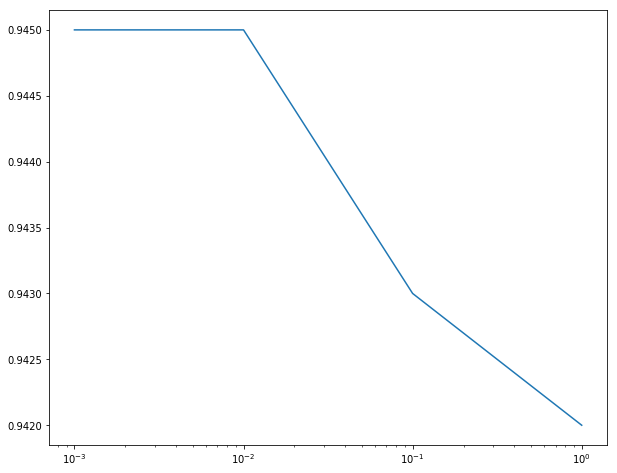

In [15]:
X = build_training_set(img_list,histogram=False)
print(X.shape,y.shape)

C = 10.**(np.arange(-3,1,1))
mean_scores = []
for c in C:
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)
plt.semilogx(C,mean_scores)

#### Hog + histogram

(2000, 1572) (2000,)


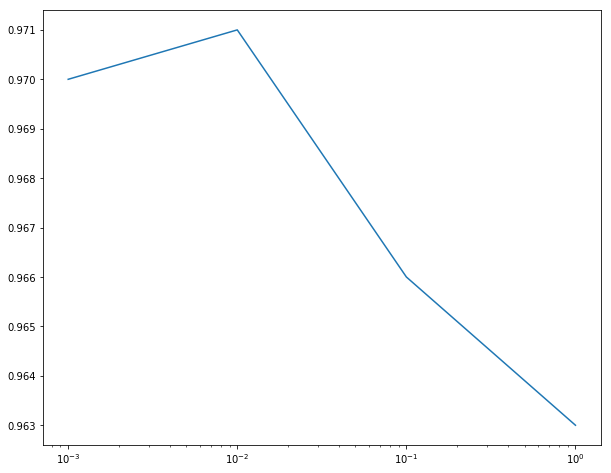

In [16]:
X = build_training_set(img_list,spatial = False)
print(X.shape,y.shape)


C = 10.**(np.arange(-3,1,1))
mean_scores = []
for c in C:
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)
plt.semilogx(C,mean_scores)

#### Hog + spatial + histogram

(2000, 4644) (2000,)


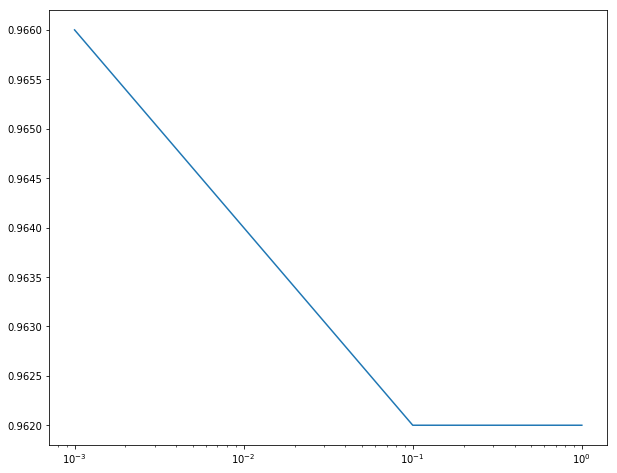

In [17]:
X = build_training_set(img_list)
print(X.shape,y.shape)


C = 10.**(np.arange(-3,1,1))
mean_scores = []
for c in C:
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)
plt.semilogx(C,mean_scores)

Conclusion, all three sets of features yields the best accuracy. Up to now, we have used a linear SVM to perform the calssification. We can check whether another linear model could reach a better performance.

We still need to select the best feature parameters.

#### Color space

[Text(0,0,'RGB'),
 Text(0,0,'HSV'),
 Text(0,0,'LUV'),
 Text(0,0,'HLS'),
 Text(0,0,'YUV'),
 Text(0,0,'YCrCb')]

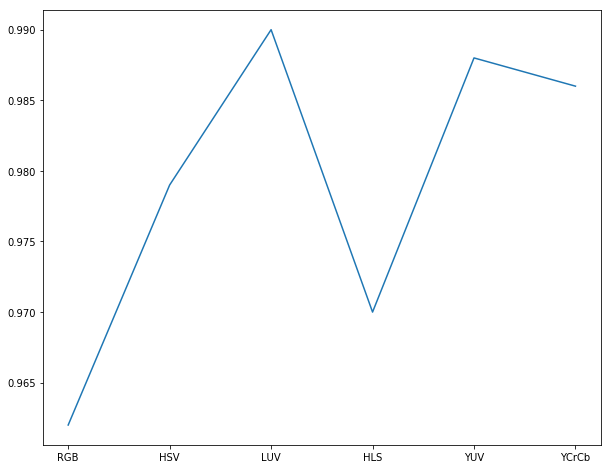

In [18]:
CS =["RGB","HSV","LUV","HLS","YUV","YCrCb"] 
mean_scores = []
for cs in CS:
    X = build_training_set(img_list, color_space=cs)
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)

fig, ax = plt.subplots()
plt.plot(mean_scores)
ax.set_xticks(np.arange(len(CS)))
ax.set_xticklabels(CS)

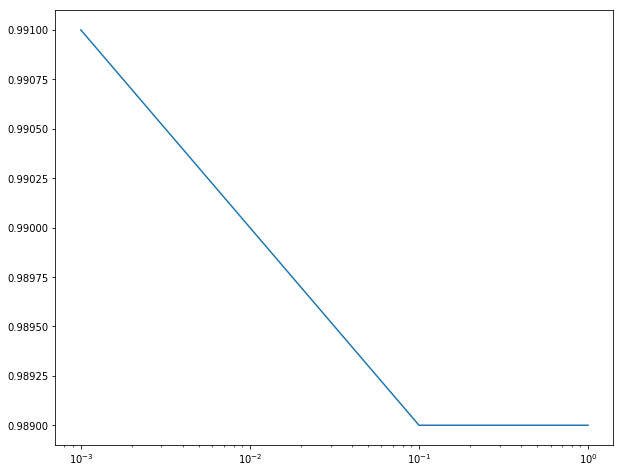

In [19]:
X = build_training_set(train_img_list, color_space='YUV')
y = np.array(labels)

C = 10.**(np.arange(-3,1,1))
mean_scores = []
for c in C:
    mean, std = eval_accuracy(X, y, LinearSVC, C=c)
    mean_scores.append(mean)
plt.semilogx(C,mean_scores)

### Train final classifier

In [20]:
def train_classifier(X,y,classifier,*args,**kwargs):
    X, y = shuffle(X, y, random_state=0)   
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    clf = classifier(*args,**kwargs)
    clf.fit(scaled_X,y)
    
    return clf, X_scaler

In [21]:
X = build_training_set(train_img_list, color_space='YUV')
y = np.array(labels)
clf, scaler = train_classifier(X, y, LinearSVC, C=1e-3)

## Searching for vehicules in images
Now we turn to the problem of detecting several vehicle in an image. To achieve that, we will subsample each image in a certain way, and pass each subimage into our classifier. 
The subsampling method will be based on a sliding window process. We first define a function that compute all the possible subimage given an image size, a subregion (defined by top left and bottom right corner), and a window size.

In [22]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

We will define several window list, that will search for vehicles at different scales.

### Small windows for far away cars


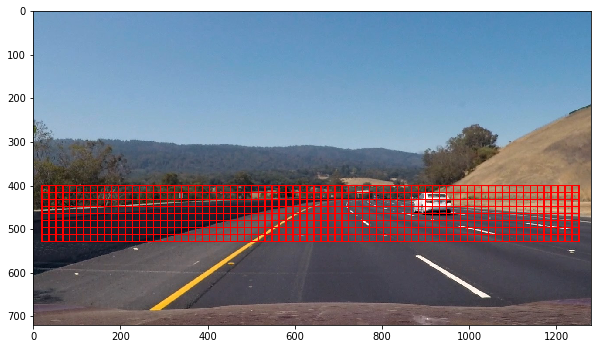

In [23]:
test_img = mpimg.imread('./test_images/test3.jpg')
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[400, 528],
                     xy_window=(64, 64), xy_overlap=(0.75, 0.75))
im = draw_bounding_boxes(test_img,boxes)

plt.figure()
plt.imshow(im)

### Bigger window for closer cars

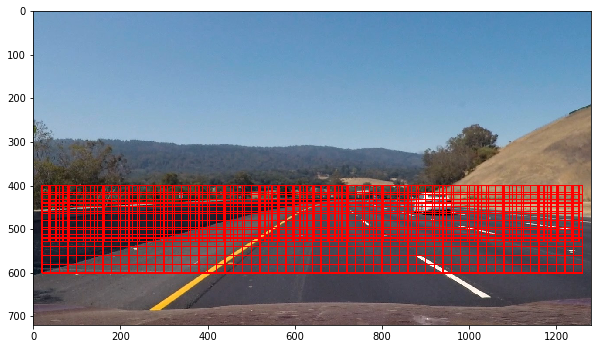

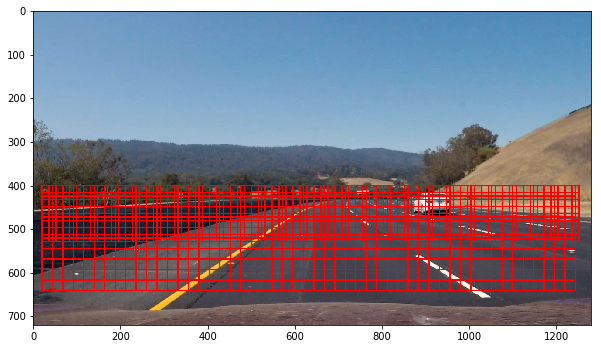

In [24]:
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[400, 600],
                         xy_window=(80, 80), xy_overlap=(0.75, 0.75))
im = draw_bounding_boxes(np.copy(test_img),boxes)

plt.figure()
plt.imshow(im)

boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[400, 640],
                     xy_window=(96, 96), xy_overlap=(0.75, 0.75))

im = draw_bounding_boxes(np.copy(test_img),boxes)

plt.figure()
plt.imshow(im)


### Big windows for very close cars

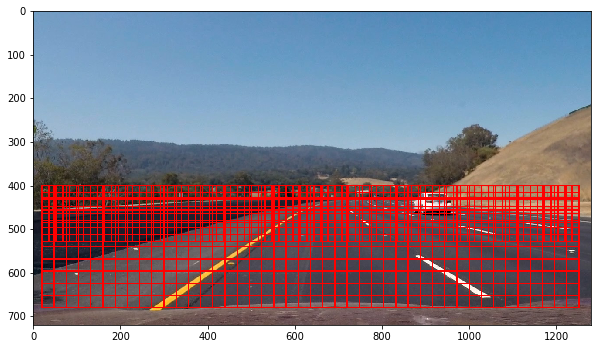

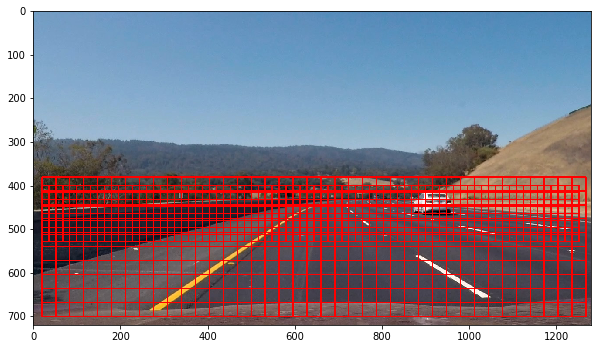

In [25]:
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[400, 680],
                     xy_window=(112,112), xy_overlap=(0.75, 0.75))
im = draw_bounding_boxes(np.copy(test_img),boxes)
plt.figure()
plt.imshow(im)

boxes = slide_window(test_img, x_start_stop=[20, 1280], y_start_stop=[380, 720],
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
im = draw_bounding_boxes(np.copy(test_img),boxes)
plt.figure()
plt.imshow(im)

Finally, we can concatenate everything to obtain a list of boxes to be searched :

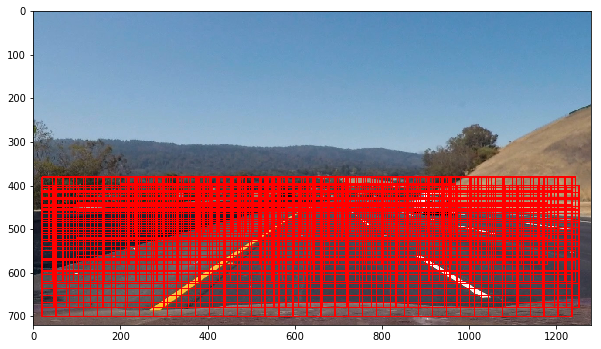

In [26]:
search_boxes = []
boxes = slide_window(test_img.shape, x_start_stop=[200, 980], y_start_stop=[380, 508],
                     xy_window=(64, 64), xy_overlap=(0.75, 0.75))
search_boxes+=boxes
boxes = slide_window(test_img.shape, x_start_stop=[100, 1180], y_start_stop=[380, 580],
                     xy_window=(80, 80), xy_overlap=(0.75, 0.75))
search_boxes+=boxes
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[380, 620],
                     xy_window=(96, 96), xy_overlap=(0.75, 0.75))
search_boxes+=boxes
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[400, 680],
                     xy_window=(112,112), xy_overlap=(0.75, 0.75))
search_boxes+=boxes
boxes = slide_window(test_img.shape, x_start_stop=[20, 1260], y_start_stop=[380, 720],
                     xy_window=(128, 128), xy_overlap=(0.75, 0.75))
search_boxes+=boxes

im = draw_bounding_boxes(np.copy(test_img),search_boxes)

plt.figure()
plt.imshow(im)

Note that since the image size coming from the camera will be constant, we can computethe list of boxes once for all.

In [27]:
print("There are %d subimage to search in each frame." %len(search_boxes))

There are 1450 subimage to search in each frame.


## Vehicle detection on single image

Now we can combine the sliding window method that selects candidate regions in a base image, and the classifier that determines if there is a car or not in the candidate region. To do that, we need to compute the feature vector that correspond to each subimage.

For color features, it is pretty straighforward. We defined a function `get_color_features` above that compute the spatial and histogram features for an image. So we can pass it the subimage, resized to the same size as training image (64x64).

For hog features, it would be inefficient to compte the hog features for each subimage. It is much more efficient to compute the HOG features for the full image, and then extract the corresponding subregion, eventually resized to get teh feature vector size expected by the classifier.

In [28]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):
#                   , color_space='RGB', 
#                    size=(32, 32), nbins=32, 
#                    bins_range=(0, 256), orient=11, 
#                    pix_per_cell=16, cell_per_block=2, spatial=True, 
#                    histogram=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    scores = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features=get_features_single_image(test_img,color_space='YUV')
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        score = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
        if score >0.7:
           on_windows.append(window)
        
    #8) Return windows for positive detections
    return on_windows

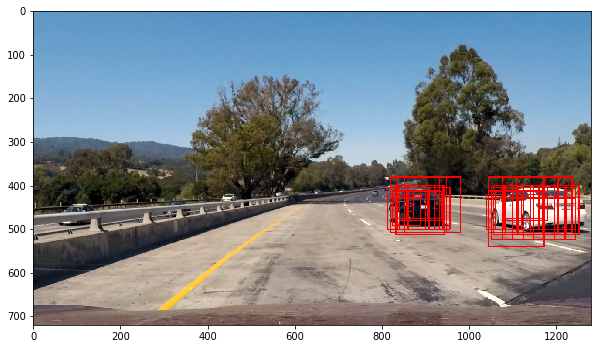

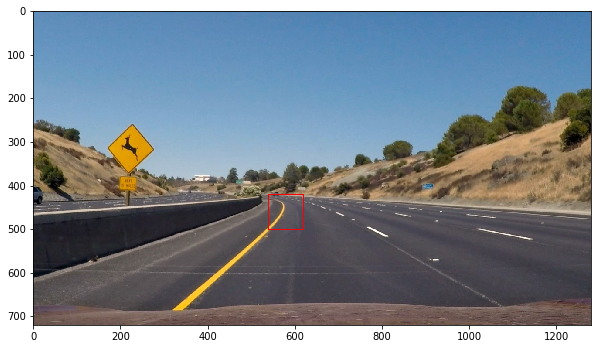

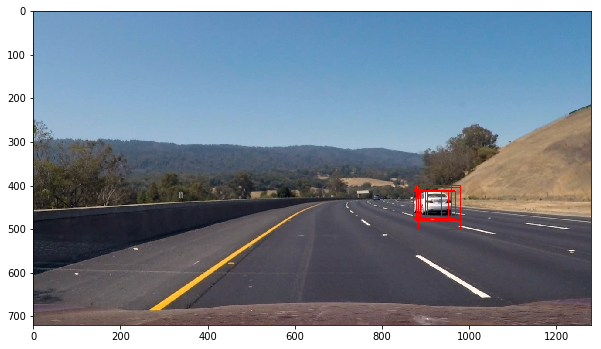

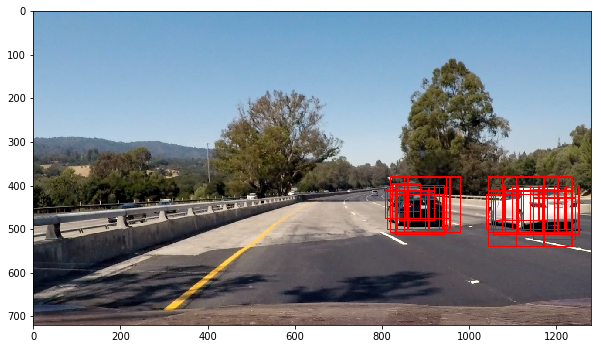

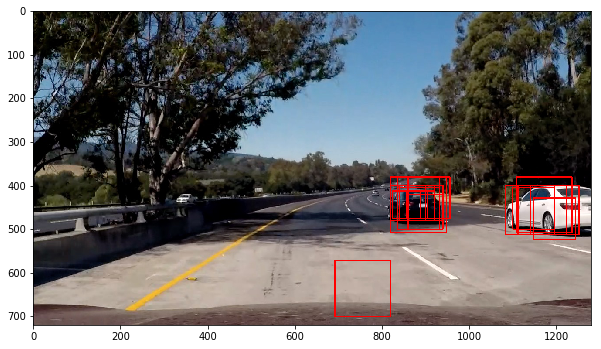

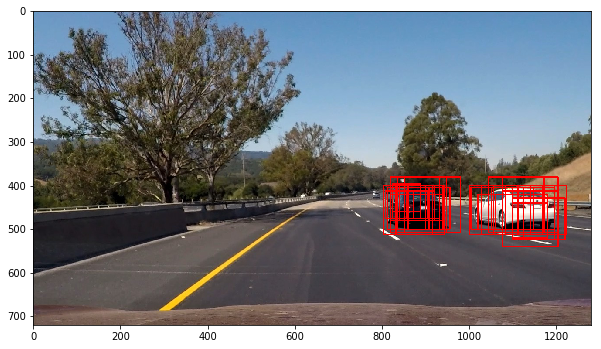

In [29]:
img_list=glob.glob('./test_images/*.jpg')
for fname in img_list:
    test_img = mpimg.imread(fname)
    test_img=test_img
    on_windows = search_windows(test_img,search_boxes,clf,scaler)
    im = draw_bounding_boxes(test_img,on_windows)
 
    plt.figure()
    plt.imshow(im)

### Heatmaps

In [30]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0.0
    # Return thresholded map
    return heatmap

def scale_heatmap(heatmap):
    if np.float(np.max(heatmap))>0:
        return heatmap/np.float(np.max(heatmap))
    else:
        return heatmap
    
def scale_heatmap_2(heatmap):
    heatmap[heatmap < 0] = 1.0
    return heatmap
    
def get_heatmap(img,box_list,threshold=1):
    heatmap = np.zeros_like(img).astype(np.float)
    heatmap = add_heat(heatmap,box_list)
    heatmap = apply_threshold(heatmap,threshold=threshold)
    heatmap = scale_heatmap(heatmap)
    
    return heatmap

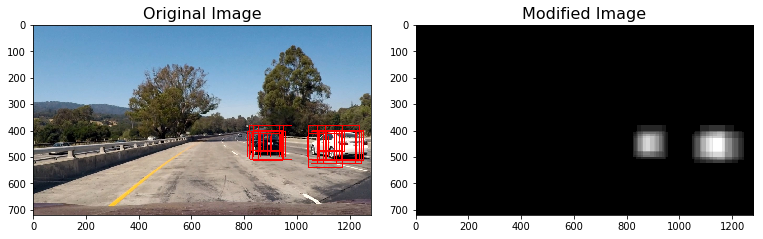

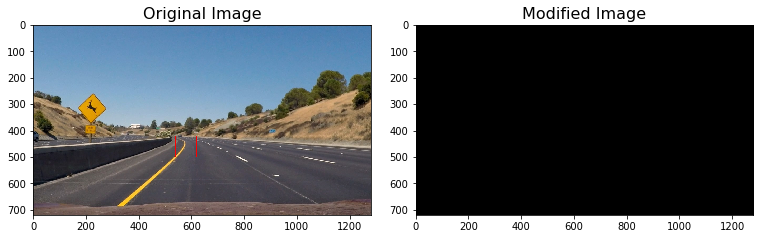

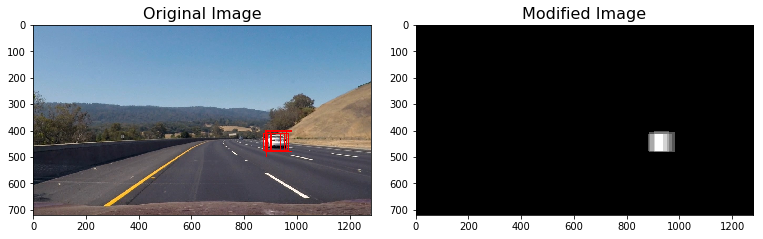

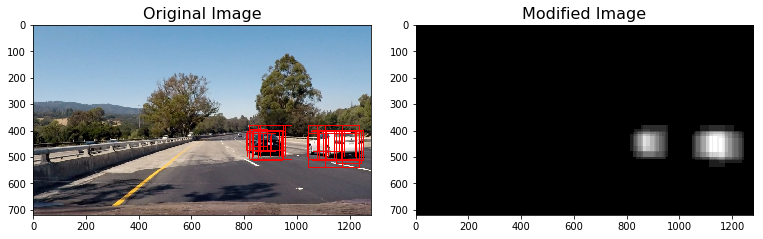

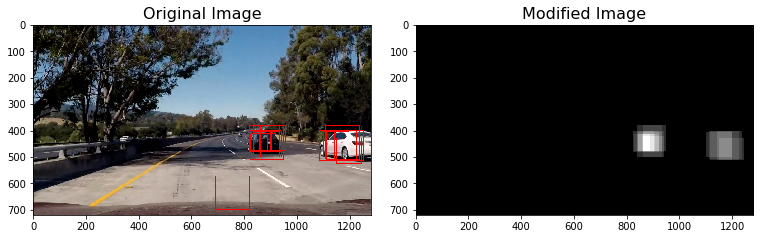

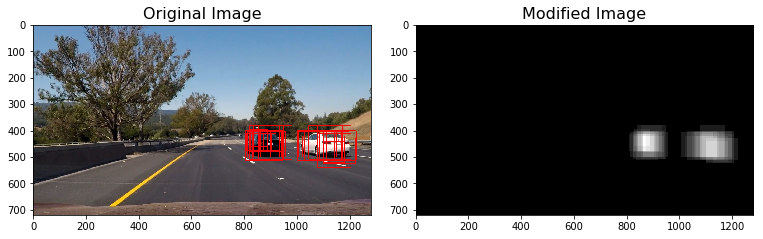

In [31]:
img_list=glob.glob('./test_images/*.jpg')
for fname in img_list:
    test_img = mpimg.imread(fname)
    test_img=test_img
    on_windows = search_windows(test_img,search_boxes,clf,scaler)
    im = draw_bounding_boxes(test_img,on_windows)
    heatmap = get_heatmap(test_img, on_windows, threshold=1) 
    plot_2_images(im,heatmap)

In [32]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

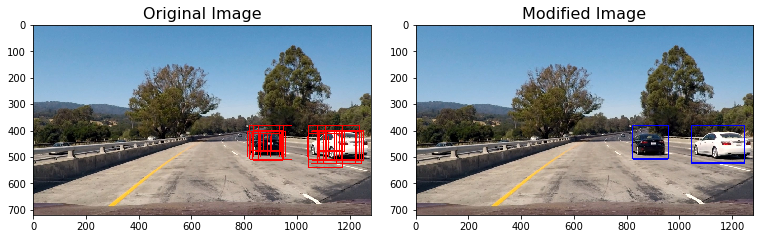

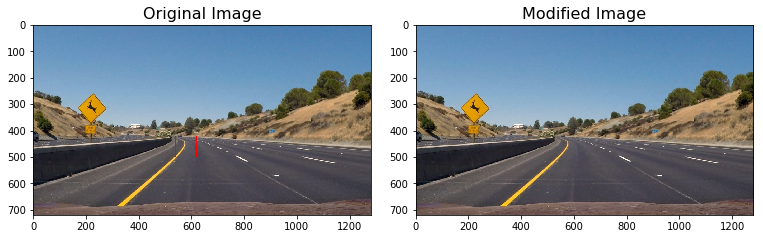

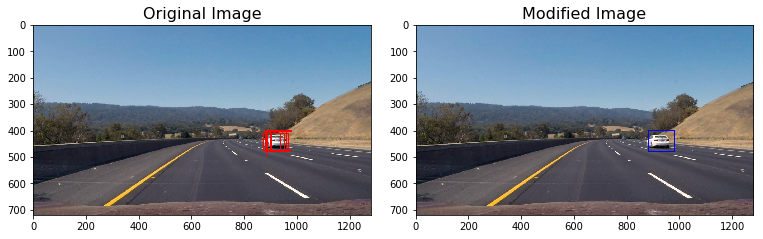

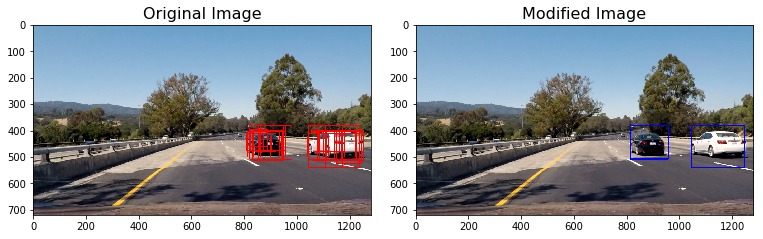

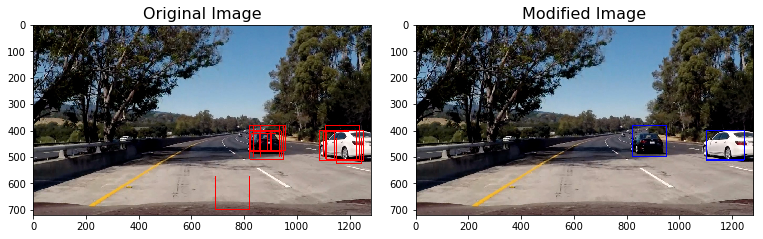

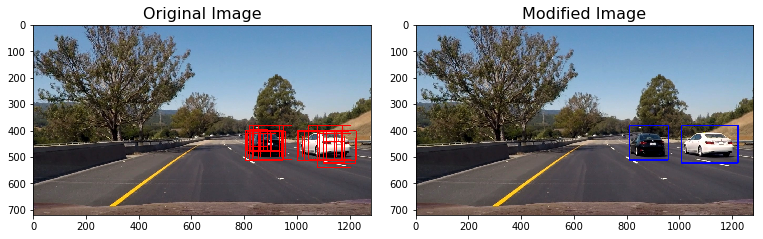

In [33]:
img_list=glob.glob('./test_images/*.jpg')
for fname in img_list:
    test_img = mpimg.imread(fname)
    on_windows = search_windows(test_img, search_boxes, clf, scaler)    
    im = draw_bounding_boxes(np.copy(test_img),on_windows)  
    heatmap = get_heatmap(test_img, on_windows, threshold=1) 
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    # Display the image
    plot_2_images(im,draw_img)

## Video Stream

In [34]:
class ImageProcessor():
    def __init__(self, shape, clf, scaler, search_boxes):
        self.shape=shape
        self.height = shape[0]
        self.width = shape[1]
        self.search_boxes = search_boxes
        self.clf = clf
        self.scaler = scaler
        self.heatmap = np.zeros(self.shape)
        self.last_heatmaps = []
        self.memory = 6 # number of frames to remember
        self.threshold = 1 
        self.count=0
    def process_image(self,image):
        on_windows = search_windows(image, self.search_boxes, self.clf, self.scaler)    
        if len(self.last_heatmaps)>self.memory:
            _ = self.last_heatmaps.pop(0)
        new_heatmap = get_heatmap(image, on_windows, threshold=self.threshold) 
        self.last_heatmaps.append(new_heatmap)
        self.heatmap = np.sum(self.last_heatmaps,axis=0)
        self.heatmap = apply_threshold(self.heatmap,threshold=self.threshold)
        labels = label(scale_heatmap(self.heatmap))
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img
   

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
output = 'output_videos/test_video_vehicle_detection.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
proc = ImageProcessor((720,1280),clf,scaler,search_boxes)
clip1 = VideoFileClip("test_videos/test_video.mp4")
clip = clip1.fl_image(proc.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video_vehicle_detection.mp4
[MoviePy] Writing video output_videos/test_video_vehicle_detection.mp4


 97%|█████████▋| 38/39 [03:00<00:04,  4.78s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video_vehicle_detection.mp4 

CPU times: user 2min 56s, sys: 2.93 s, total: 2min 59s
Wall time: 3min 1s


In [38]:
output = 'output_videos/project_video_vehicle_detection.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
proc = ImageProcessor((720,1280),clf,scaler,search_boxes)
clip1 = VideoFileClip("test_videos/project_video.mp4")
clip = clip1.fl_image(proc.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_vehicle_detection.mp4
[MoviePy] Writing video output_videos/project_video_vehicle_detection.mp4


100%|█████████▉| 1260/1261 [42:38<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_vehicle_detection.mp4 

CPU times: user 40min 41s, sys: 1min 36s, total: 42min 18s
Wall time: 42min 39s


**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!